# 05 - Taming Text

In this homework we will explore a relatively large corpus of emails released during the Hillary Clinton email controversy.

Importing useful librairies

In [1]:
import pandas as pd
import numpy as np

import os

from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt  
% matplotlib inline
import random

from datetime import datetime

import nltk
from nltk import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk.sentiment.util


import pycountry
import seaborn as sns

Reading the csv containing the emails

In [2]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv", usecols=['ExtractedSubject','RawText', 'ExtractedBodyText', 'ExtractedFrom'])
emails.head()

,ExtractedSubject,ExtractedFrom,ExtractedBodyText,RawText
0,FW: Wow,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,NaN,NaN,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,Re: Chris Stevens,"Mills, Cheryl D <MillsCD@state.gov>",Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
3,FVV: Cairo Condemnation - Final,"Mills, Cheryl D <MillsCD@state.gov>",NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
4,NaN,NaN,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",B6\r\nUNCLASSIFIED\r\nU.S. Department of State...


Binding all the text from the emails

In [3]:
def createTextFromTokens(text_list):
    text = " ".join(str(x) for x in text_list)
    text = text.replace("\n", " ") 
    return text

In [4]:
print("Percentage of null in field BodyText :", emails.ExtractedBodyText.isnull().sum()/len(emails.ExtractedBodyText), "%")
print("Percentage of null in field RawText :",  emails.RawText.isnull().sum()/len(emails.RawText),  "%")

Percentage of null in field BodyText : 0.151415984896 %
Percentage of null in field RawText : 0.0 %


In [5]:
all_text = createTextFromTokens( emails['ExtractedBodyText'].str.lower())

Creating the World Cloud

In [6]:
wc = WordCloud(max_words=1000, mask=None, stopwords=None, margin=10, width = 800, height = 400,
               random_state=1).generate(all_text)

Displaying the World Cloud

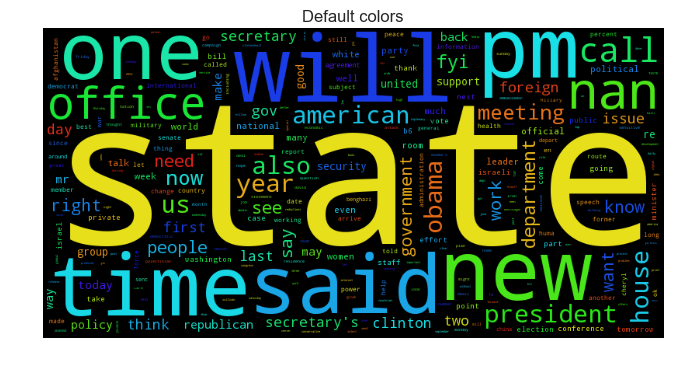

In [7]:
def display_cloud(wc) :
    default_colors = wc.to_array()
    plt.figure()
    plt.title("Default colors")
    plt.imshow(default_colors)
    plt.axis("off")
    plt.show()
    return

display_cloud(wc)

We will first tokenize the text

In [8]:
tokens_raw = nltk.word_tokenize(all_text)


In [9]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(('state', 'fyi', 'wa', 'nan', 'ha', 'n\'t', 'sent', 'case', 'gov', 'said', 'original', 'callb6', 'message', 'release', 'department', 'clintonemail', 'pm', 'unclassified', 'date', 'doc', 'subject'))

### discuss stemmer vs lemmatizer

In [10]:
porter = nltk.PorterStemmer()
stemmed = [porter.stem(t) for t in tokens_raw]
wnl = nltk.WordNetLemmatizer()
lemmatized = [wnl.lemmatize(t) for t in tokens_raw]

In [11]:
tokens = [w for w in lemmatized if w.lower() not in stopwords]
print(len(tokens) / len(tokens_raw))

0.6278696281850901


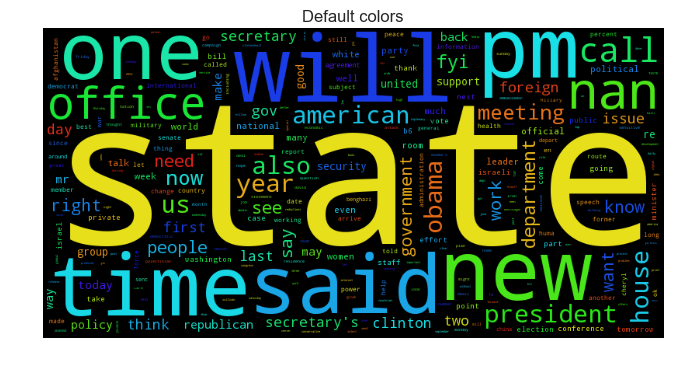

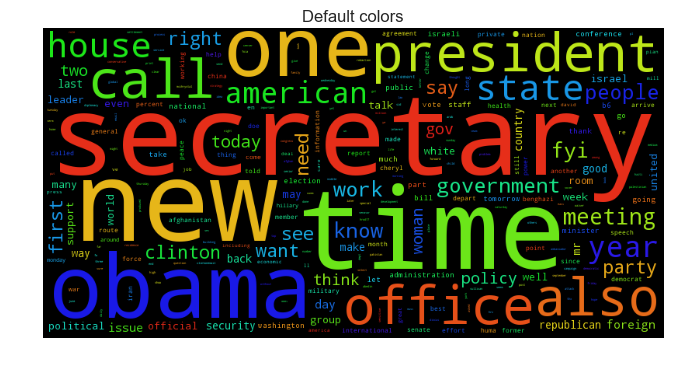

In [12]:
wc_processed = WordCloud(max_words=1000, mask=None, stopwords=None, margin=10,  width = 800, height = 400, 
                         random_state=1).generate(createTextFromTokens(tokens))
display_cloud(wc)
display_cloud(wc_processed)

We could skim it some more, but what is appearing through these wordclouds is that these emails were definitely relating to her functions as secretary.

## 2. World countries

In [13]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv", usecols=['ExtractedBodyText'])
emails.dropna( subset = ['ExtractedBodyText'], inplace = True)

countries = []
for i in range(0, len(pycountry.countries)) :
    countries.append(list(pycountry.countries)[i].alpha_2)


#### Vader method

In [14]:
#Redefine the Vader method demo instance by returning the compound value of the analyzer instead of printing it
def demo_vader(text):
    """
    Output polarity scores for a text using Vader approach.

    :param text: a text whose polarity has to be evaluated.
    """
    from nltk.sentiment import SentimentIntensityAnalyzer
    vader_analyzer = SentimentIntensityAnalyzer()
    return vader_analyzer.polarity_scores(text)['compound']

In [ ]:
#We compute the polarity score for each mail using the VADER method before attributing them to each countries 
# allowing us to save the list to a .csv to avoid the computation time in the future.
vader = []
for email in emails['ExtractedBodyText']:
    vader.append(demo_vader(email.lower()))
    
vader_df = pd.DataFrame(vader, columns=["Vader"])
vader_df.to_csv('vader.csv', index=False)

#### Liu Hu Opinion Lexicon method

In [59]:
#Redefine the Liu Hu opinion lexicon method demo by returning the classification value of the analyzer instead of printing it
def demo_liuhu(sentence):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.

    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) # negative
        else:
            y.append(0) # neutral

    if pos_words > neg_words:
        return 1.0
    elif pos_words < neg_words:
        return -1.0
    elif pos_words == neg_words:
        return 0.0


In [ ]:
#We compute the polarity score for each mail using the LIU HU LEXICON method before attributing them to each countries 
# allowing us to save the list to a .csv to avoid the computation time in the future.
liuhu = []
for email in emails['ExtractedBodyText']:
    liuhu.append(demo_liuhu(email.lower()))
    
liuhu_df = pd.DataFrame(liuhu, columns=["Liu Hu"])
liuhu_df.to_csv('liuhu.csv', index=False)

### PAS AU POINT

In [108]:
#If we look up countries by their 2 letters code, a lot of care must be given not to mismatch an english word or abbreviation capitalized with on such country.
#We escape the codes with whitespaces not to mix them with regular capitalized words, and we delete the common short words mistaken for countries.
#Our parsing is not perfect but overall decent.

for email in emails['ExtractedBodyText']:
    for j in range(0, len(pycountry.countries)) :
        if (' ' + list(pycountry.countries)[j].alpha_2 + ' ') in email and list(pycountry.countries)[j].alpha_2 not in 'BY TV TO NO SE PM IN AM FM PR' :
            print(list(pycountry.countries)[j].alpha_2)

WS
PA
PA
AQ
AQ
AQ
AQ
AU
SG
US
AT
BY
TV
US
US
NC
TV
US
AR
SL
CM
SL
US
US
US
US
CA
MA
LA
BY
MA
US
US
AT
BY
US
MA
MA
DE
US
TV
DO
AT
US
CV
US
GE
US
US
VI
US
US
US
MA
TV
ME
GA
GA
US
BY
US
US
MC
US
US
US
TV
US
US
US
US
AT
PA
AQ
SL
US
US
GM
US
US
BY
US
IS
US
US
TV
US
US
NI
US
US
MP
US
US
BI
SS
US
DE
US
CA
VA
US
US
US
IQ
AT
MU
US
IL
DE
AU
US
PA
MM
KM
US
US
US
IO
MA
US
SO
US
US
MP
AU
US
BY
CG
JO
LA
TV
US
SO
US
US
VI
US
US
NI
MM
NI
US
TV
MM
US
ME
GB
MP
NI
US
US
TV
US
US
GB
US
AU
US
US
US
NI
US
NI
US
AT
IS
US
NI
GB
AT
BY
US
US
US
MP
TV
US
VA
CD
US
US
TV
US
US
US
AT
BE
US
HK
TT
AT
AL
AT
US
BY
US
TV
US
GB
US
PA
US
US
ME
US
MP
NI
US
US
BY
US
US
TV
US
EC
SG
AT
TV
US
US
SM
US
MP
CD
US
PA
US
US
BY
BY
GB
US
US
RS
US
US
MP
AT
JO
TV
US
US
TV
AF
MP
BY
BN
US
US
GM
US
GI
US
US
US
US
US
US
JP
LA
US
US
CV
SS
AT
US
US
BY
US
US
AS
QA
TV
US
AT
US
PA
US
CO
DE
MA
US
US
US
US
BY
CR
US
AT
GA
SG
US
IL
IL
LA
AS
BE
IS
US
BY
AI
TV
SG
SG
TV
CA
CG
CA
BY
US
SS
TV
TV
US
US
AU
JO
PL
US
TV
SS
US
BY
TT
SO
BY
BY
NI
BY
US
TV
TV
U

In [95]:
#Here also we must take care to do some cleaning and not aggregate all the occurences of the alpha codes blindly.
#for instance, the Libyan city Bengazhi, which is mentioned often, would be read as BEN + GHA, Benin and Ghana. So we escape 
#the alpha code again with whitespaces. VAT refers to the VAT Number, etc...
for email  in emails['ExtractedBodyText']:
    for j in range(0, len(pycountry.countries)) :
        if (' ' + list(pycountry.countries)[j].alpha_3 + ' ') in email and list(pycountry.countries)[j].alpha_3 not in 'AND POL VAT GEO EST' :
            print(list(pycountry.countries)[j].alpha_3)

CHN
RUS
USA
NGA
TUV
TUV
USA
SOM
PRT
USA
USA
NAM
USA
USA
USA
USA
USA
USA
USA
USA
USA


# OK - A COMMENTER DAVANTAGE

In [109]:
vader = pd.read_csv("vader.csv", usecols=['Vader'])['Vader'].values.tolist()
liuhu = pd.read_csv("liuhu.csv", usecols=['Liu Hu'])['Liu Hu'].values.tolist()

countries_polarity = pd.DataFrame(countries, columns=['Country'])
countries_polarity['Occurences'] = 0
countries_polarity['Vader'] = 0.0
countries_polarity['Liu Hu'] = 0.0
countries_polarity.set_index("Country", inplace=True)

#For now, find countries by their full names
for email, i  in zip(emails['ExtractedBodyText'], range(0,len(emails['ExtractedBodyText']))):
    for j in range(0, len(pycountry.countries)) :
        if list(pycountry.countries)[j].name.lower() in email.lower():
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Occurences'] += 1
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Vader'] += vader[i]
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Liu Hu'] += liuhu[i]
                
    for j in range(0, len(pycountry.countries)) :
        if (' ' + list(pycountry.countries)[j].alpha_2 + ' ') in email and list(pycountry.countries)[j].alpha_2 not in 'BY TV TO NO SE PM IN AM FM PR' :
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Occurences'] += 1
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Vader'] += vader[i]
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Liu Hu'] += liuhu[i]            
                
        if (' ' + list(pycountry.countries)[j].alpha_3 + ' ') in email and list(pycountry.countries)[j].alpha_3 not in 'AND POL VAT GEO EST' :
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Occurences'] += 1
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Vader'] += vader[i]
                countries_polarity.loc[list(pycountry.countries)[j].alpha_2, 'Liu Hu'] += liuhu[i]            

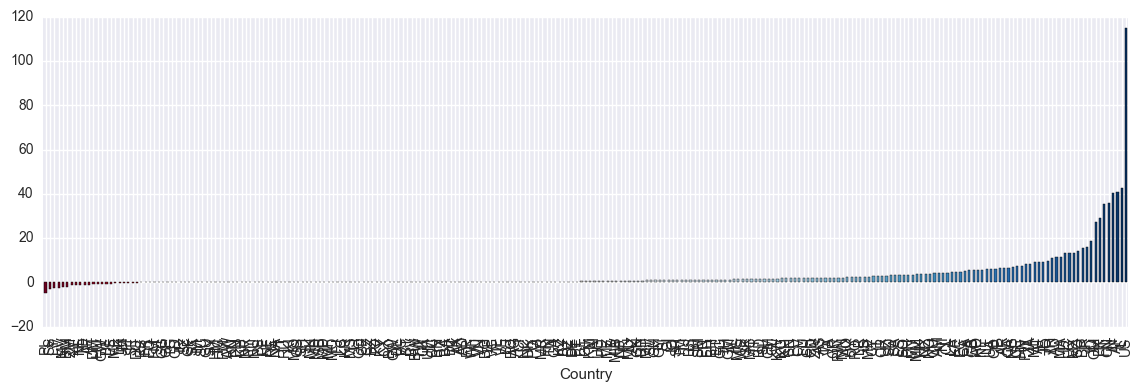

In [113]:
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity))
countries_polarity.sort_values(by='Vader').Vader.plot(kind='bar', figsize=(14,4), color= palette);
                

C:\Users\Mathieu\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\Mathieu\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


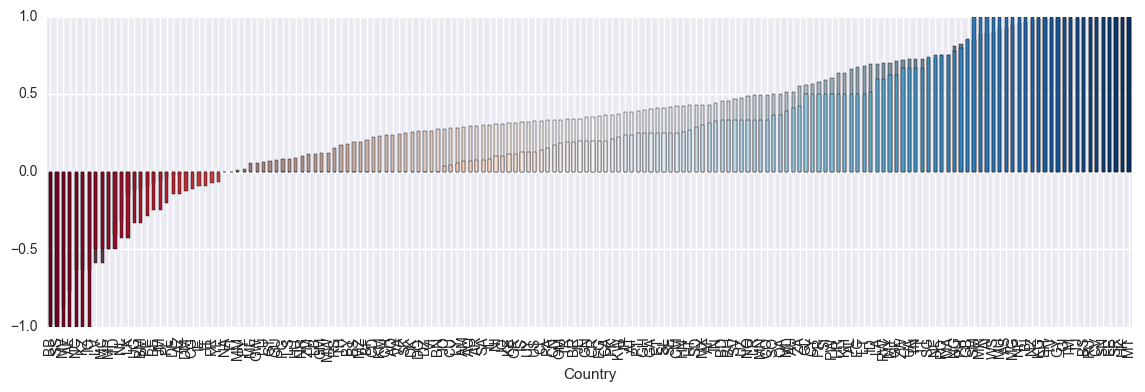

In [110]:
#Delete countries that are never mentioned in Clinton's emails
countries_polarity_plot_normalized = countries_polarity[countries_polarity['Occurences'] > 0]
#Normalize the polarity
countries_polarity_plot_normalized.Vader = countries_polarity_plot_normalized.Vader.div(countries_polarity_plot_normalized.Occurences, axis='index')
countries_polarity_plot_normalized['Liu Hu'] = countries_polarity_plot_normalized['Liu Hu'].div(countries_polarity_plot_normalized.Occurences, axis='index')
#Plot the polarity
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity_plot_normalized), desat=.3)
countries_polarity_plot_normalized.sort_values(by='Vader').Vader.plot(kind='bar', figsize=(14,4), color= palette);
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity_plot_normalized))
countries_polarity_plot_normalized.sort_values(by='Liu Hu')['Liu Hu'].plot(kind='bar', figsize=(14,4), color= palette);

46


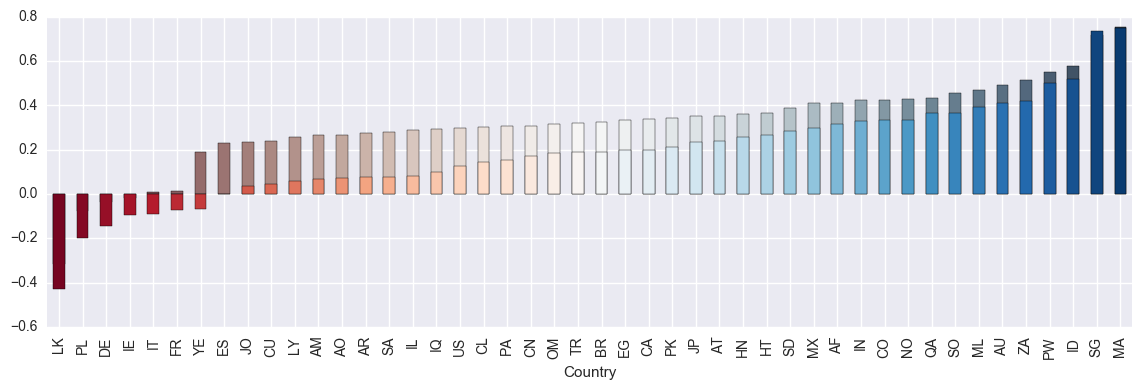

In [111]:
print(len(countries_polarity[countries_polarity['Occurences'] > 10]))
countries_polarity_plot_normalized = countries_polarity_plot_normalized[countries_polarity_plot_normalized['Occurences'] > 10]
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity_plot_normalized), desat=.3)
countries_polarity_plot_normalized.sort_values(by='Vader').Vader.plot(kind='bar', figsize=(14,4), color= palette);
palette = sns.color_palette("RdBu", n_colors=len( countries_polarity_plot_normalized))
countries_polarity_plot_normalized.sort_values(by='Liu Hu')['Liu Hu'].plot(kind='bar', figsize=(14,4), color= palette);